In [1]:
import logging
import sys
import os
from os import getenv
from os.path import abspath, basename, split,dirname
import tarfile
from shutil import copyfile
import random, glob
from skimage.util import random_noise
from skimage.transform import rotate
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import gmean

import tensorflow as tf
import tensorflow_datasets as tfds
#import efficientnet.keras as efn
#from efficientnet.tfkeras import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB3, EfficientNetB2, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Flatten, Concatenate, Cropping2D
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
IMG_SIZE = 224
LBL = dict(zip(['B_BSMUT1', 'B_CLEV5B', 'B_DISTO', 'B_GRMEND', 'B_HDBARL',
       'B_PICKLD', 'B_SKINED', 'B_SOUND', 'B_SPRTED', 'B_SPTMLD',
       'O_GROAT', 'O_HDOATS', 'O_SEPAFF', 'O_SOUND', 'O_SPOTMA',
       'WD_RADPODS', 'WD_RYEGRASS', 'WD_SPEARGRASS', 'WD_WILDOATS',
       'W_DISTO', 'W_FLDFUN', 'W_INSDA2', 'W_PICKLE', 'W_SEVERE',
       'W_SOUND', 'W_SPROUT', 'W_STAIND', 'W_WHITEG'], range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

model_version = '001'

# Work around for a SageMaker path issue
# (see https://github.com/aws/sagemaker-python-sdk/issues/648)
# WARNING - removing this may cause the submission process to fail
#if abspath("D:/Ramdhan/Unearth/visual-grain-analysis") not in sys.path:
 #   sys.path.append(abspath("D:/Ramdhan/Unearth/visual-grain-analysis"))

def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def get_subfolders(directory):
    subfolders = os.listdir(directory)
    subfolders.sort()
    return subfolders

def save_class_list(class_list):
    class_list.sort()
    target=open("class_list.txt",'w')
    for c in class_list:
        target.write(c)
        target.write("\n")

def get_num_files(directory):
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

def rotate_tensor(image):
    degree = tf.random.normal([])*360
    image = tfa.image.rotate(image, degree * math.pi / 180)
    return image

def input_preprocess_train(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    image = rotate_tensor(image)
    #image = tf.cast(image,'float32')#/255.0 #activate for densenet
    image = preprocess_input(image)
    return image, label

def input_preprocess_val(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    #image = tf.cast(image,'float32')#255.0 #activate for densenet
    image = preprocess_input(image)
    return image, label

def train(args):
    global NUM_CLASSES
    """Train
    """
    logger.info("calling training function")

    ### Build the tensorflow dataset from downloaded files
    
    TRAIN_DIR = os.path.join(args['data_dir'],  'train')
    VAL_DIR = os.path.join(args['data_dir'], 'val')
    
    class_list = get_subfolders(TRAIN_DIR)
    NUM_CLASSES = len(class_list)
    save_class_list(class_list)
    
    size = (IMG_SIZE, IMG_SIZE)
    batch_size = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=size,
        batch_size=batch_size,
        interpolation='nearest')

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        image_size=size,
        batch_size=batch_size,
        interpolation='nearest')
    
    train_ds = train_ds.map(input_preprocess_train)
    val_ds = val_ds.map(input_preprocess_val)
    
    #ds_build_cmd = "tfds build grains --manual_dir=" + args['data_dir']
    #logger.info(ds_build_cmd)
    #os.system(ds_build_cmd)

    logger.info("Training Model")
    #strategy = tf.distribute.MirroredStrategy()
    
    #dataset_name = "grains"
    #(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "val"], with_info=True, as_supervised=True)

    num_train_images = get_num_files(TRAIN_DIR)
    num_val_images = get_num_files(VAL_DIR)

    logger.info("number of classes is " + str(NUM_CLASSES))

    #with strategy.scope():
    #model = build_model(num_classes=NUM_CLASSES)
    #model = build_model_bilinear(num_classes=NUM_CLASSES)
    model = build_MDNet_custom()
    filename = 'best.h5'
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
    checkpoint = ModelCheckpoint(filename, monitor='val_acc_grain', verbose=1, save_best_only=True, mode='max')
    stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, mode= 'min', min_delta=0.00)
    lr_schedule= get_cosine_schedule_with_warmup(lr=0.001, num_warmup_steps=4, num_training_steps=10)

    # This comes from an environment variable so we can set it to 1 for our
    # development pipeline. Feel free to set this to any value.
    weights = dict(zip([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], [1,1,1,1,1,1,1,8.94,1,1,1,1,1,8.94,1,1,1,1,1,1,1,1,1,1,8.94,1,1,1]))
    
    history = model.fit(train_ds, epochs=10, validation_data=val_ds, shuffle=True,
                        callbacks=[stop,checkpoint,lr_schedule],#steps_per_epoch=num_train_images/batch_size,
              verbose=1, class_weight=weights 
                        #, workers=0, steps_per_epoch=num_train_images // batch_size, 
        #, validation_steps=num_val_images // batch_size,shuffle=True
                        #,callbacks=callbacks_list
                       )
    #save_model(model,args['model_dir'])
    #save_model(model,filename)
    
    return history

def build_MDNet_custom(num_classes=28, img_dim=(224,224,3), num_pipelines=4, dropout_rate=0.5, decrease_by=0.25):
    '''
    MDNet parameters as stated in the paper:
    num_classes = 9,
    img_dim = (112, 112, 3),
    num_pipelines = 4,
    num_blocks = 4,
    num_layers = 5,
    num_filters = 8 (?),
    dropout_rate = .5,
    decrease_by = .25
    '''
   
    assert img_dim[0] == img_dim[1]
    assert num_pipelines > 1
    pipelines = []

    model_input = Input(shape = img_dim)
    
    model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(None, None, 3), pooling='avg')
    
    for layer in model.layers[:-1]:
        layer.trainable = False

    # Number of pipelines
    for pipeline_idx in range(num_pipelines):

        new_dim = int(img_dim[0] * (pipeline_idx * decrease_by)) if pipeline_idx != 0 else img_dim[0]
        crop_by = int(new_dim/2) if pipeline_idx != 0 else 0

        x = Cropping2D(cropping = crop_by, name = 'Cropped_by_' + str(crop_by))(model_input)
        
        out = model(x)
        
        pipelines.append(out)
    
    x = Concatenate(axis = -1)(pipelines)
    
    x = Dropout(dropout_rate)(x)

    # Two fully connected layers
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    model_output = Dense(num_classes, activation = 'softmax', name='pred')(x)
    model = Model(inputs = model_input, outputs = model_output, name = "MDNet")
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[acc_grain],run_eagerly=True)
    
    return model

def acc_grain(y_true, y_pred):
    y_true_class = K.argmax(y_true, axis=-1)
    y_pred_class = K.argmax(y_pred, axis=-1)
    sample_weight = np.hstack((np.where(y_true_class.numpy().reshape(-1,1)==7,True,False),np.where(y_true_class.numpy().reshape(-1,1)==24,True,False),np.where(y_true_class.numpy().reshape(-1,1)==13,True,False)))
    sample_weight = np.any(sample_weight,axis=1)
    sample_weight = np.where(sample_weight,8.94,1.0)
    return K.constant(accuracy_score(y_true_class,y_pred_class,sample_weight=sample_weight))
    
def save_model(model, model_dir):
    """Save model to a binary file.

    This function must write the model to disk in a format that can
    be loaded from the model_fn.

    WARNING - modifying this function may cause the submission process to fail.
    """
    #sm_model_dir = os.path.join(model_dir, model_version)
    sm_model_dir = model_dir
    if (not os.path.isdir(sm_model_dir)):
        os.makedirs(sm_model_dir)
        
    logger.info(f" model dir is {model_dir}")
    model.save(sm_model_dir)
    
    modelPath = os.path.join(sm_model_dir, 'output')
    if (not os.path.isdir(modelPath)):
        os.makedirs(modelPath)
    #if (not os.path.isdir(sm_model_dir + '/code')):
        #os.makedirs(sm_model_dir + '/code')

    # Move inference.py so it gets picked up in the archive
    #copyfile('/content/sample_data/inference.py', sm_model_dir + '/code/inference.py')
    #copyfile('/content/sample_data/inference-requirements.txt', sm_model_dir+ '/code/requirements.txt')

    with tarfile.open(os.path.join(modelPath, 'model.tar.gz'), mode='x:gz') as archive:
        archive.add(sm_model_dir, recursive=True)

def model_fn(model_dir):
    """Load model from binary file.

    This function loads the model from disk. It is called by SageMaker.

    WARNING - modifying this function may case the submission process to fail.
    """
    #model_filepath = os.path.join(model_dir,  model_version)
    #logger.info("loading model from " + model_filepath)
    model = keras.models.load_model('best.h5',custom_objects={'acc_grain':acc_grain},compile=False)
    return model

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [5]:
if __name__ == "__main__":
    """Training Main

    The main function is called by both Unearthed's SageMaker pipeline and the
    Unearthed CLI's "unearthed train" command.
    
    WARNING - modifying this function may cause the submission process to fail.

    The main function must call preprocess, arrange th
    """
    
    args = {'model_dir': "D:/Ramdhan/Unearth/visual-grain-analysis/models/",
           'data_dir' : "D:/Ramdhan/Unearth/visual-grain-analysis/data/public/"}
    start = time.time()
    history = train(args)
    print('duration run',(time.time()-start)/60/60,' hours')

INFO:__main__:calling training function


Found 19182 files belonging to 28 classes.
Found 7648 files belonging to 28 classes.


C:\Users\Owner\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)
INFO:__main__:Training Model
INFO:__main__:number of classes is 28



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/10
600/600 [==============================] - ETA: 0s - loss: 27.8429 - acc_grain: 0.0239
Epoch 00001: val_acc_grain improved from -inf to 0.01010, saving model to best.h5
600/600 [==============================] - 645s 1s/step - loss: 27.8429 - acc_grain: 0.0239 - val_loss: 3.5973 - val_acc_grain: 0.0101

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 2/10
600/600 [==============================] - ETA: 0s - loss: 3.5621 - acc_grain: 0.8808
Epoch 00002: val_acc_grain improved from 0.01010 to 0.94413, saving model to best.h5
600/600 [==============================] - 645s 1s/step - loss: 3.5621 - acc_grain: 0.8808 - val_loss: 1.4043 - val_acc_grain: 0.9441

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 3/10
600/600 [==============================] - ETA: 0s - loss: 2.2051 - acc_grain: 0.9204
Epoch 00003: val_acc_grain improved from 0.94413 to 0.95238, sav

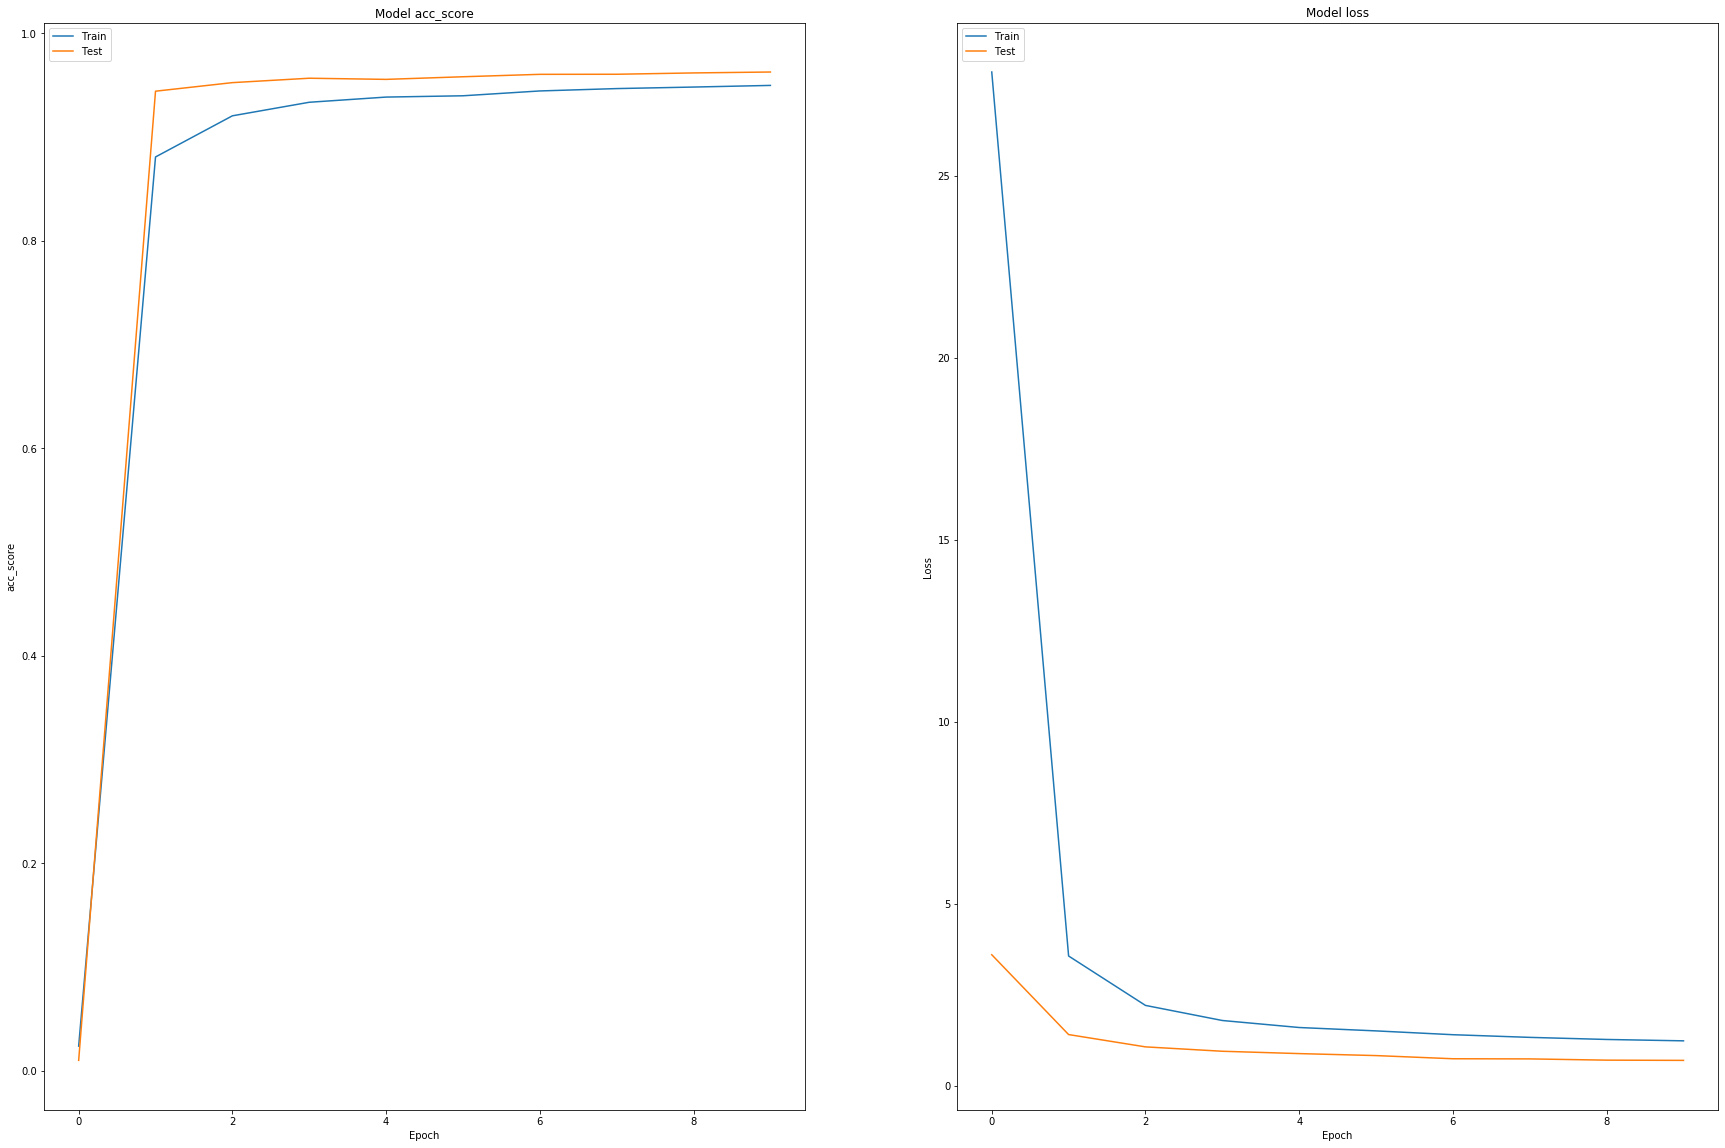

In [6]:
import matplotlib.pyplot as plt
# Plot training & validation iou_score values
plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.plot(history.history['acc_grain'])
plt.plot(history.history['val_acc_grain'])
plt.title('Model acc_score')
plt.ylabel('acc_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-180, 180)
    return rotate(image_array, random_degree, mode='edge')

def defined_rotation(image_array, degree):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    return rotate(image_array, degree, mode='edge')

def random_rotation_tensor(image):
    degree = tf.random.normal([])*360
    image = tf.convert_to_tensor(image, np.float32)
    image = tfa.image.rotate(image, degree * math.pi / 180)
    return image.numpy()

In [14]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """
        pred = []
        #angle = [45,90,135,180,225, 270,315, 360]
        #p0 = self.model.predict(X)
        #pred.append(p0.ravel())
        for i in range(5):
            if i ==0:
                p = self.model.predict(X)
            else:
                #p = self.model.predict(np.expand_dims(random_rotation(X[0]),axis=0)) 
                #p = self.model.predict(np.expand_dims(defined_rotation(X[0],angle[i]),axis=0))
                p = self.model.predict(np.expand_dims(random_rotation_tensor(X[0]),axis=0)) 
            pred.append(p.ravel())
        #return np.expand_dims(np.mean(np.array(pred),axis=0),axis=0) 
        return np.expand_dims(gmean(np.array(pred),axis=0),axis=0) 

In [15]:
from tensorflow.keras.preprocessing import image
import pandas as pd
import zipfile
import csv
from tta_wrapper import tta_segmentation

start = time.time()

def load_class_list(class_list_file):
    class_list = []
    with open(class_list_file, 'r') as csvfile:
        file_reader = csv.reader(csvfile)
        for row in file_reader:
            class_list.append(row[0])
    class_list.sort()
    return class_list

class_list = load_class_list('class_list.txt')

IMG_SIZE=224
LBL = dict(zip(class_list, range(28)))

cls_map = dict(zip(LBL.values(),LBL.keys()))

def init_dir(pth):
    if os.path.exists(pth):
        shutil.rmtree(pth)
    os.mkdir(pth)

logger.info("loading the model")
model = model_fn(args['model_dir'])
logger.info("Reading the test set")

#model1 = tta_classification(model, h_flip=False, rotation=(0, 360), merge='mean')
model = TTA_ModelWrapper(model)
#model1 = myPredictor(model,conf)

res = []
for fn in glob.iglob(args['data_dir'] + 'val/**/*.png', recursive=True):
    file_name = os.path.basename(fn)
    path = os.path.abspath(fn)
    folder = os.path.split(os.path.dirname(path))[1]
    if len(file_name.split("-")) > 2:  # ignore master image with may grains, raw image names are in guid format
        im = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(im)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        pred = model.predict(img_preprocessed)
        top3 = (-pred[0]).argsort()[:3]
        res.append({'file_name': file_name, 'path': path, 'cls': folder, 'prediction':top3[0],  'proba_1':pred[0][top3[0]], 'prediction2':top3[1], 'proba_2':pred[0][top3[1]],  'prediction3':top3[2], 'proba_3':pred[0][top3[2]]})

df = pd.DataFrame(res)
df['prediction'] = df.prediction.map(cls_map)
df['prediction2'] = df.prediction2.map(cls_map)
df['prediction3'] = df.prediction3.map(cls_map)

from sklearn.metrics import accuracy_score

def w(x):
    if "_SOUND" in x:
        return 8.94 # weighting  Healthy grains more important than defective grains
    return 1

def scoring_fn(df):
    """
    Weighted Accuracy Metric 90% Healthy grains, 10% unhealthy grains
    """
    df['weight'] = df.cls.apply(w)
    return accuracy_score(df.cls,df.prediction,sample_weight=df.weight)

logger.info(f"predictions have shape of {df.shape}")

score = scoring_fn(df)
print ("Accuracy Score:" + str(score))
# write to the output location

print('Duration Run',(time.time()-start)/3600,' hours')

INFO:__main__:loading the model
INFO:__main__:Reading the test set
C:\Users\Owner\Anaconda3\envs\object_detection_gpu\lib\site-packages\tensorflow_addons\image\transform_ops.py:143: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  "fill_value is not supported and is always 0 for TensorFlow < 2.4.0."
INFO:__main__:predictions have shape of (7648, 9)


Accuracy Score:0.9665901232206283
Duration Run 0.8838400470548206  hours


In [ ]:
0.965

In [9]:
from sklearn.metrics import classification_report
print(classification_report(df['cls'], df['prediction']))

               precision    recall  f1-score   support

     B_BSMUT1       0.98      0.90      0.94       105
     B_CLEV5B       0.95      0.41      0.57       100
      B_DISTO       0.93      0.43      0.59       100
     B_GRMEND       0.98      0.51      0.67        88
     B_HDBARL       0.67      0.33      0.44        30
     B_PICKLD       0.96      0.47      0.63        92
     B_SKINED       1.00      0.20      0.34        88
      B_SOUND       0.81      1.00      0.89      1653
     B_SPRTED       1.00      0.87      0.93        93
     B_SPTMLD       0.90      0.23      0.37       112
      O_GROAT       1.00      0.78      0.88        90
     O_HDOATS       0.76      0.26      0.39        99
     O_SEPAFF       0.94      0.72      0.81       109
      O_SOUND       0.92      1.00      0.96      1988
     O_SPOTMA       0.83      0.29      0.43       103
   WD_RADPODS       0.99      0.99      0.99        94
  WD_RYEGRASS       0.96      0.94      0.95        87
WD_SPEARG

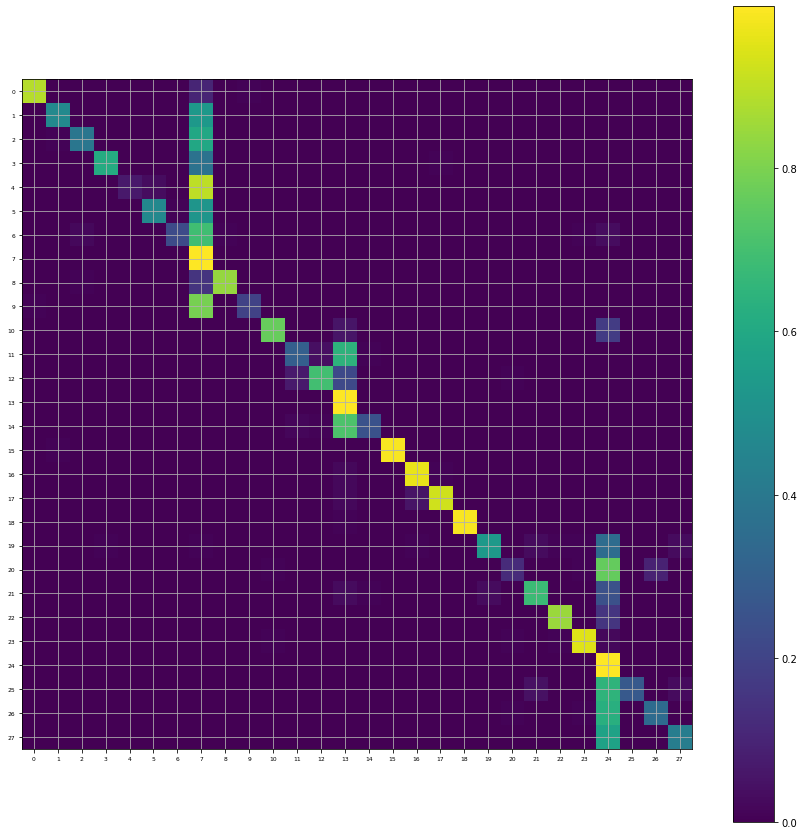

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ticks=np.linspace(0, 27,num=28)
plt.figure(figsize=(15,15))
plt.imshow(confusion_matrix(df['cls'], df['prediction'],normalize='true'), interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()

In [ ]:
from keras_preprocessing import image

In [ ]:
NUM_CLASSES=28
model = build_model(num_classes=NUM_CLASSES)
model.fit?

In [ ]:
image.random_rotation(90)

In [ ]:
 rotation_range=args.rotation,
      shear_range=args.shear,
      zoom_range=args.zoom,
      horizontal_flip=args.h_flip,
      vertical_flip=args.v_flip